# Домашнее задание 4

В последнем практическом задании мы потренируемся в построении VaR- и ES-кривой для небольшого портфеля. Каждый актив (акцию или валюту) далее будем называть инструментом.

### 1) Загрузка данных (бесценно)

* Представьте, что вы инвестор и собираете инвестиционный портфель.

* Загрузите данные по трём любым акциям и двум любым валютам за последние 10 лет. Акции и валюты выберите на ваш вкус, но интереснее будет взять что-то кроме евро/доллара/акций гугла.

* Можно использовать YahooFinance либо другие источники при желании.

* Переведите цены в доходности. Можно использовать лог-доходности или процентные изменения на выбор.



In [10]:
import pandas as pd
import yfinance as yf
import numpy as np

tickers = ['TSLA', 'AAPL', 'NVDA']
start_date = '2013-05-26'
end_date = '2023-05-26'

stock_data = yf.download(tickers, start=start_date, end=end_date)['Close']

currency_pairs = ['JPY=X', 'CNY=X']
currency_data = yf.download(currency_pairs, start=start_date, end=end_date)['Close']

portfolio_data = pd.concat([stock_data, currency_data], axis=1)
portfolio_data.columns = ['TSLA', 'AAPL', 'NVDA', 'JPY/USD', 'CNY/USD']

returns = np.log(portfolio_data / portfolio_data.shift(1)).dropna()

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  2 of 2 completed


### 2. Визуализация.

#### 2.1 (0.5 балла)
Изобразите парные диаграммы рассеяния (scatterplot) для всех комбинаций инструментов. В каких парах наблюдается связь, а в каких нет? Кратко интерпретируйте зависимость по одному примеру из предыдущего вопроса (один где есть зависимость, другой где нет). Если во всех парах есть зависимость (или во всех нет), то достаточно одного примера.

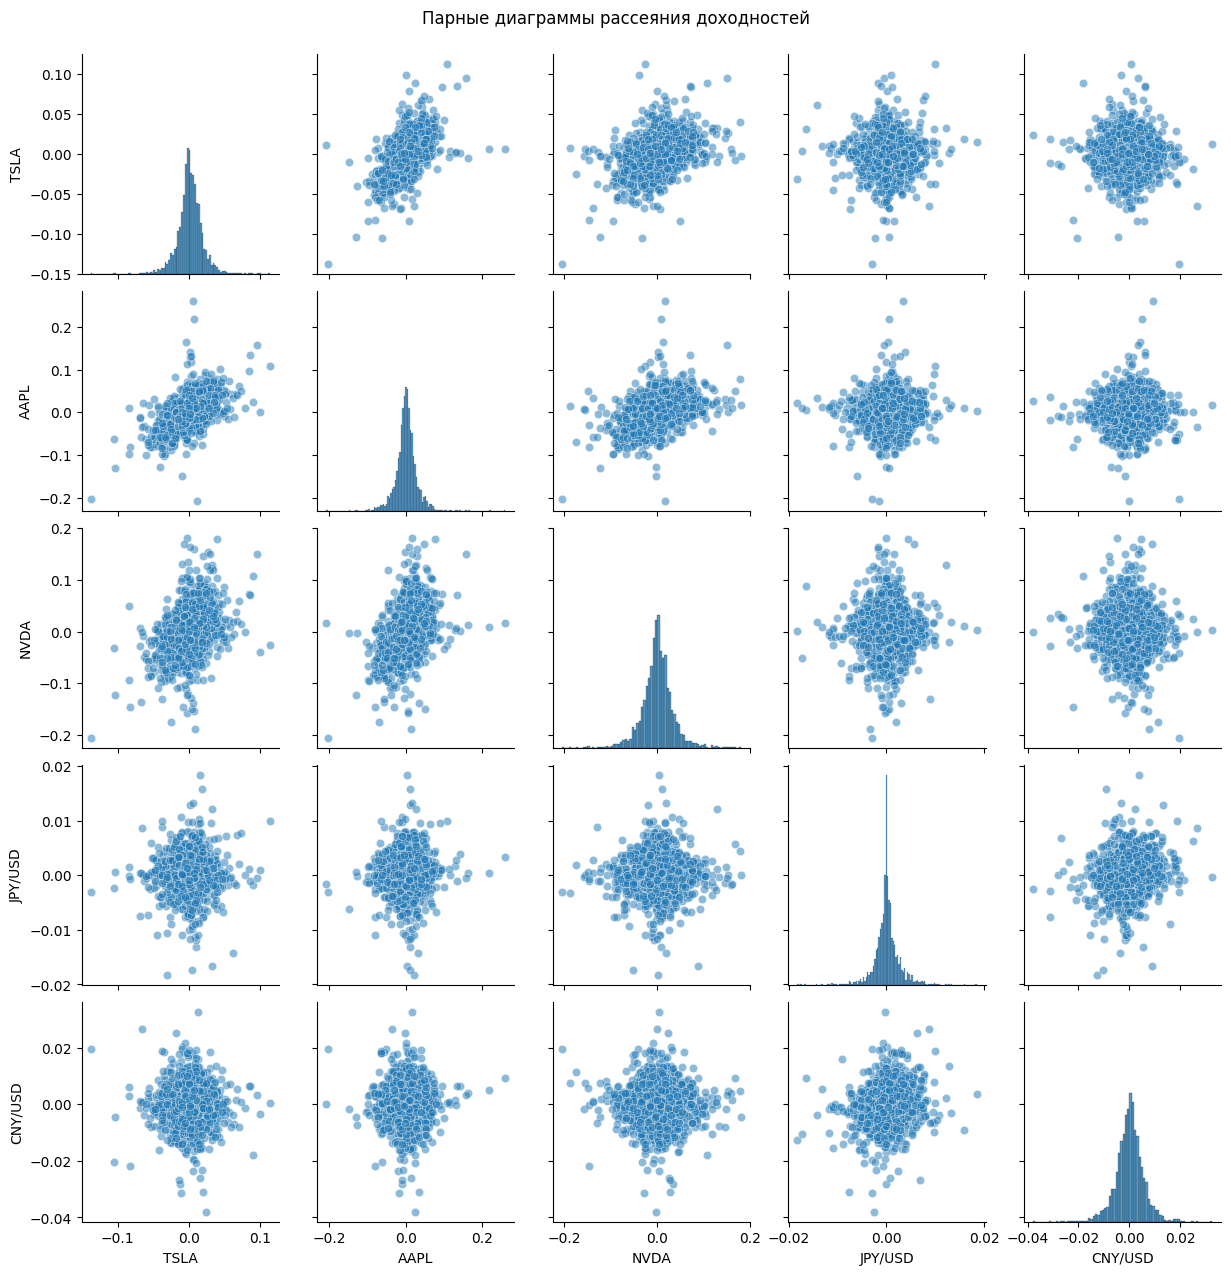

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(returns, kind='scatter', plot_kws={'alpha': 0.5})
plt.suptitle("Парные диаграммы рассеяния доходностей", y=1.02)
plt.show()

Зависимость наблюдается: AAPL и TSLA - видна положительная линейная зависимость, так как точки вытянуты вдоль восходящей диагонали. Это логично, так как это акции технологического сектора, которые часто движутся синхронно.

В остальных случаях зависимости не видно.

#### 2.2 (1 балл)
Изобразите гистограмму распределения каждого инструмента, наложив на неё оценённое нормальное распределение. Прокомментируйте характеристики распределения доходностей.

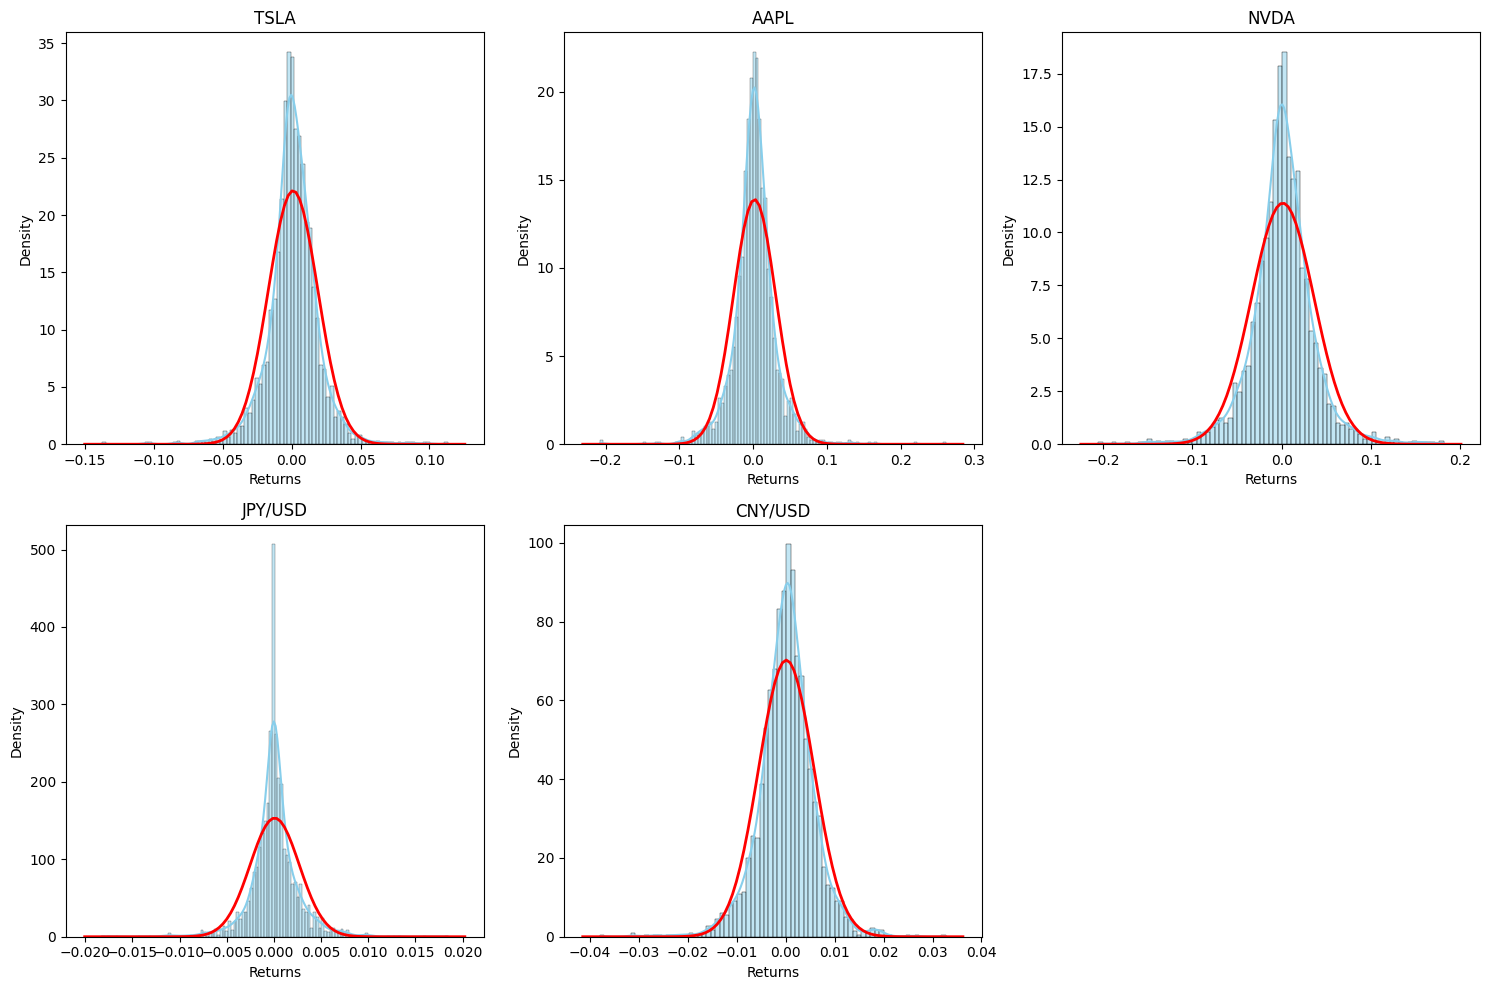

In [13]:
import scipy.stats as stats

plt.figure(figsize=(15, 10))
for i, col in enumerate(returns.columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(returns[col], kde=True, stat='density', color='skyblue')

    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, returns[col].mean(), returns[col].std())
    plt.plot(x, p, 'r', linewidth=2)

    plt.title(col)
    plt.xlabel('Returns')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

У всех инструментов наблюдаются более тяжелые хвосты, чем предсказывает нормальное распределение. Особенно заметно у NVDA.

Все распределения имеют более высокий пик по сравнению с нормальным распределением.

Некоторые распределения (например, TSLA) демонстрируют асимметрию.


#### 2.3 (0.5 балла)
В качестве весов портфеля используйте веса на момент покупки (как в семинаре). Изобразите  гистограмму распределения доходностей портфеля, наложив на неё оценённое нормальное распределение. Прокомментируйте характеристики распределения доходностей.

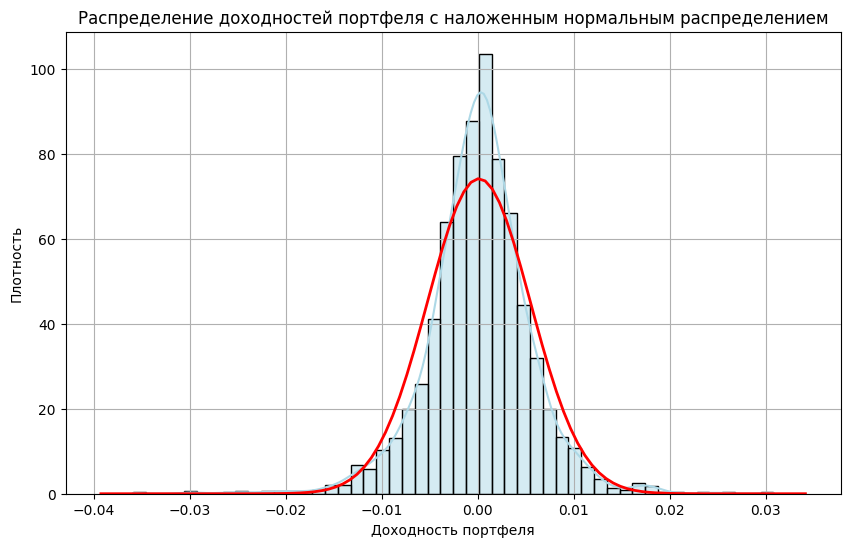

In [14]:
initial_prices = portfolio_data.iloc[0]
weights = initial_prices / initial_prices.sum()

portfolio_returns = (returns * weights).sum(axis=1)

plt.figure(figsize=(10, 6))
sns.histplot(portfolio_returns, kde=True, stat='density', color='lightblue', bins=50)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, portfolio_returns.mean(), portfolio_returns.std())
plt.plot(x, p, 'r', linewidth=2)

plt.title('Распределение доходностей портфеля с наложенным нормальным распределением')
plt.xlabel('Доходность портфеля')
plt.ylabel('Плотность')
plt.grid(True)
plt.show()


#### 2.4 (0.5 балла)
Придумайте, опишите и примените альтернативную стратегию взвешивания. Поясните, почему она имеет смысл.

### **Альтернативная стратегия взвешивания: волатильностно-взвешенный портфель**  

**Описание стратегии:**  
Вместо равных весов или весов по начальной стоимости, назначаем веса обратно пропорционально исторической волатильности (стандартному отклонению доходностей) каждого актива. Это означает, что:  
- Активы с **высокой волатильностью** (например, TSLA) получат **меньший вес**.  
- Активы с **низкой волатильностью** (например, JPY/USD) получат **больший вес**.  

**Формула весов:**  

$w_i$ = $\frac{1/\sigma_i}{\sum_{j=1}^n{(1/\sigma_j)}}$

где $\sigma_i$ — стандартное отклонение доходностей i-го актива.  

**Преимущества стратегии:**  
1. **Снижение общей волатильности портфеля** – поскольку мы ограничиваем влияние самых рискованных активов.  
2. **Более стабильная доходность** – портфель меньше подвержен резким колебаниям.  
3. **Автоматическая балансировка** – если волатильность актива растёт, его вес уменьшается.  

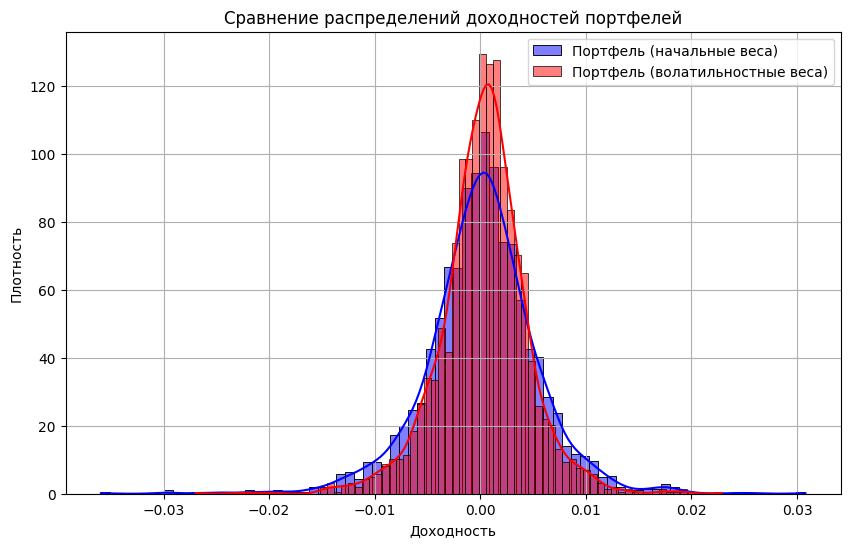

In [15]:
volatility = returns.std()

weights_vol = (1 / volatility) / (1 / volatility).sum()

portfolio_returns_vol = (returns * weights_vol).sum(axis=1)

plt.figure(figsize=(10, 6))
sns.histplot(portfolio_returns, kde=True, stat='density', color='blue', alpha=0.5, label='Портфель (начальные веса)')
sns.histplot(portfolio_returns_vol, kde=True, stat='density', color='red', alpha=0.5, label='Портфель (волатильностные веса)')
plt.title('Сравнение распределений доходностей портфелей')
plt.xlabel('Доходность')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True)
plt.show()

### 3. Анализ отдельных инструментов. (2 балла, по 0.4 за инструмент)

* Подберите для каждого инструмента наиболее подходящее маржинальное распределение. Можно использовать всё, что есть в scipy, а также garch-модель.
* Для каждого результата изобразите калибровочную кривую (qq-plot), а также наложите оценённую функцию плотности на гистограмму распределения доходности. Прокомментируйте графики.

Обратите внимание, что для GARCH-модели подход будет особенный в плане построения qq-plot и гистограммы. Как мы помним из формулы ниже, дисперсия у нас представлена умножением условной волатильности на распределение. Поэтому на qq-plot и гистограмме нужно будет визуализировать стандартизированные остатки против функции плотности $\epsilon$.

$$r_{t+1} = \mu_t  + \sqrt{h_t}\epsilon_t \text{  with  } \epsilon_t \sim N(0, 1)$$


NB! Постарайтесь подобрать распределение как можно точнее, от этого существенно зависит итоговый результат.


TSLA: johnsonsu (AIC=-13000.7)


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003249. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


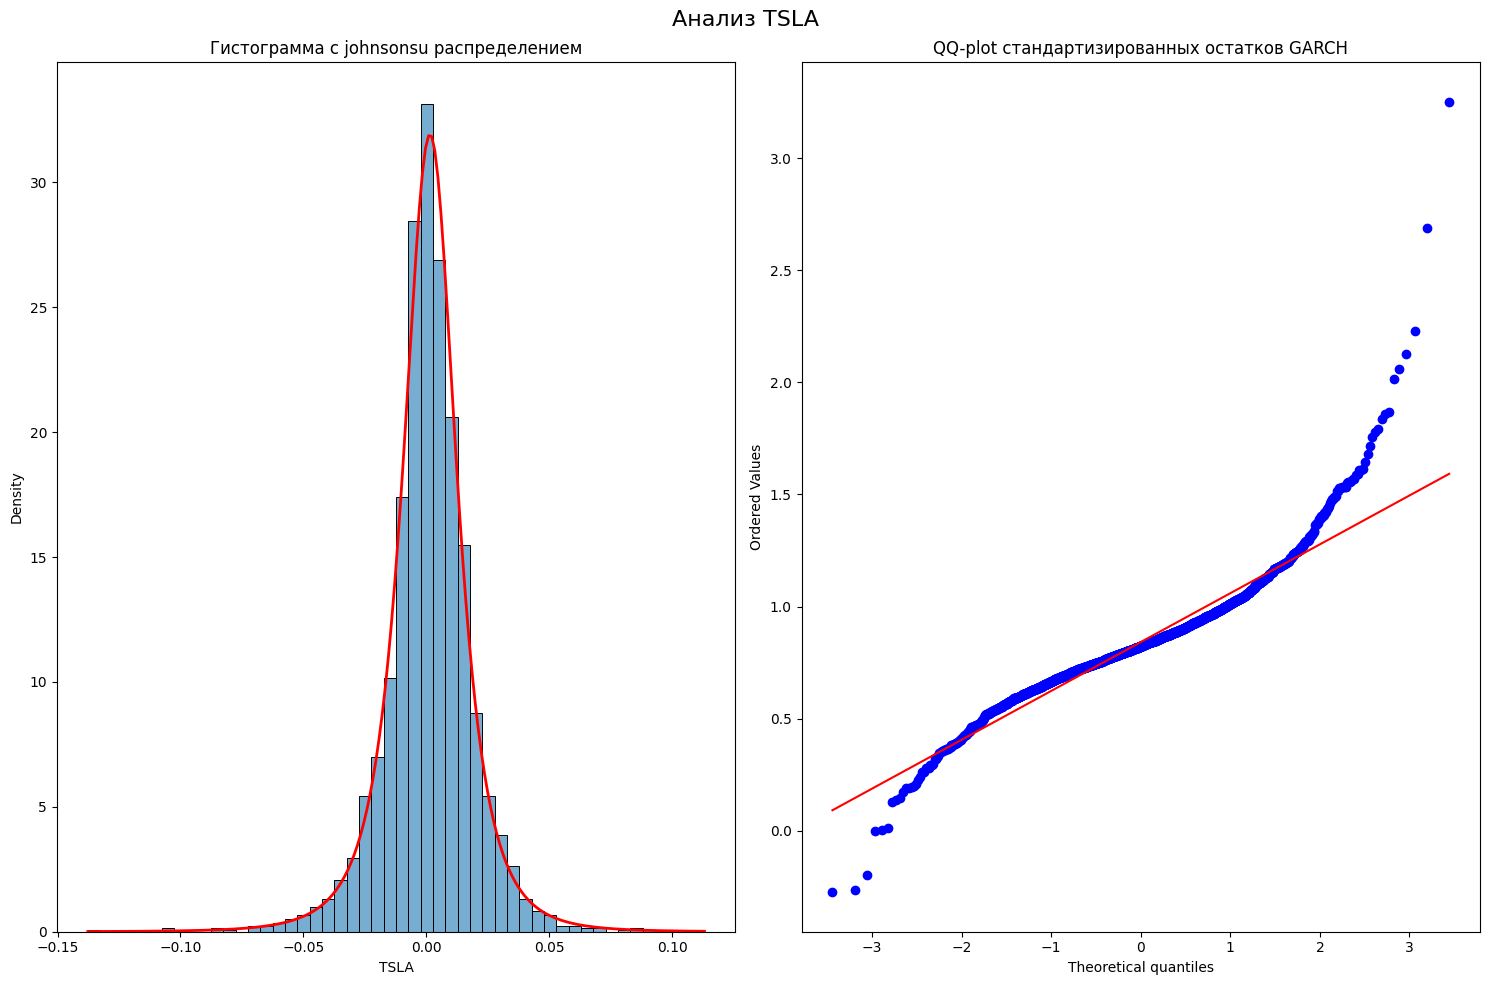

AAPL: genhyperbolic (AIC=-10878.4)


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000825. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


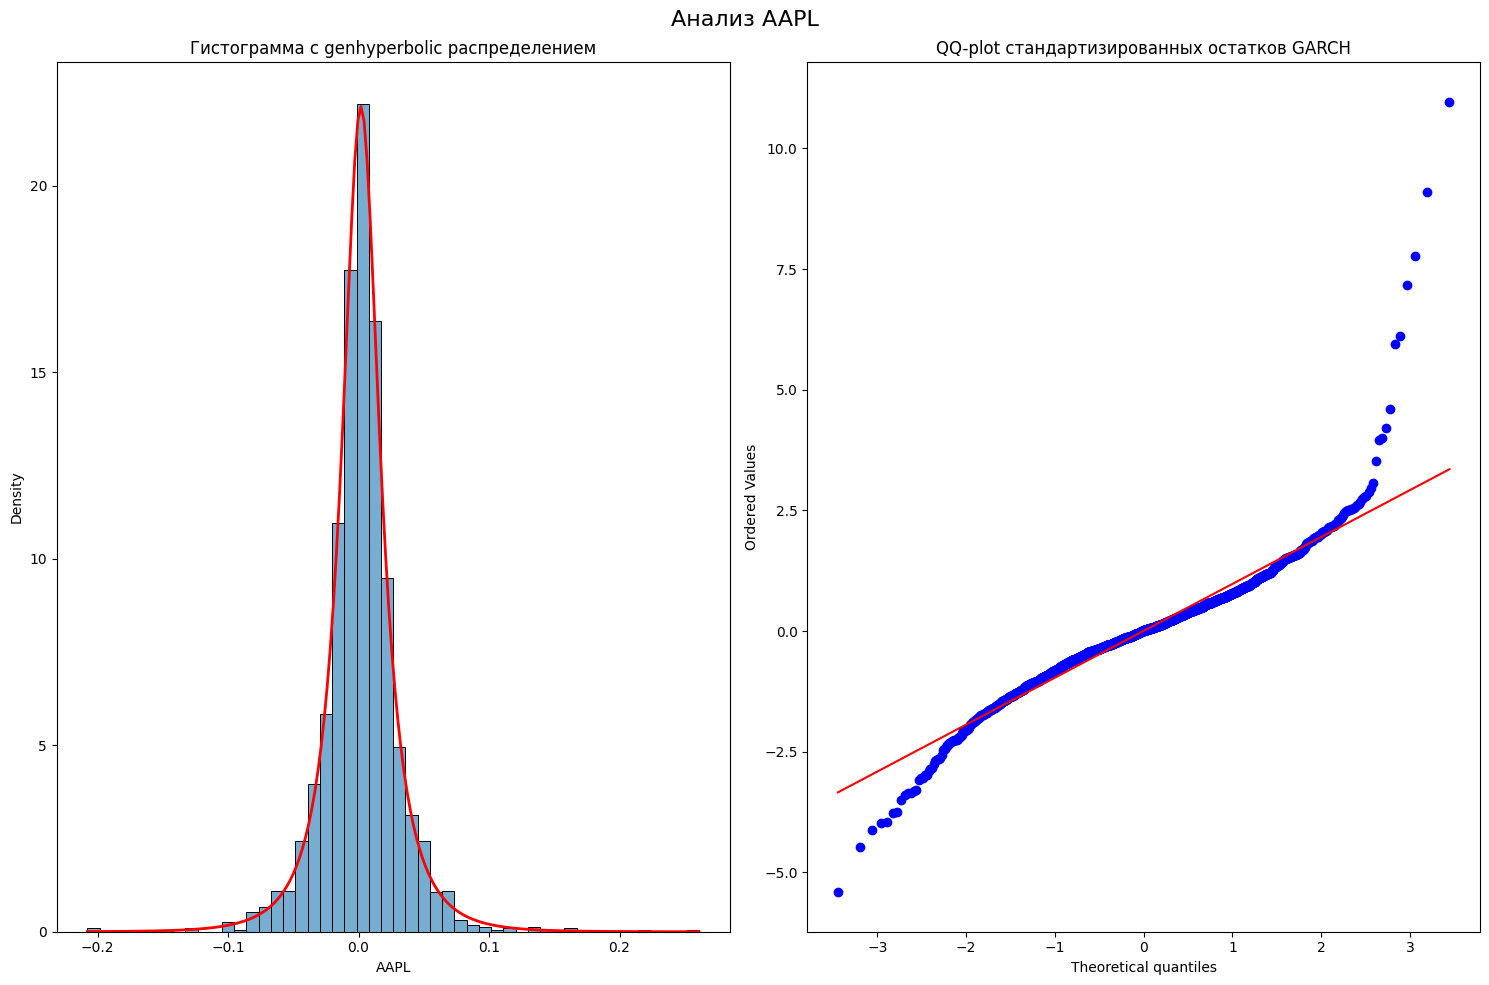

NVDA: laplace (AIC=-9770.0)


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001227. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


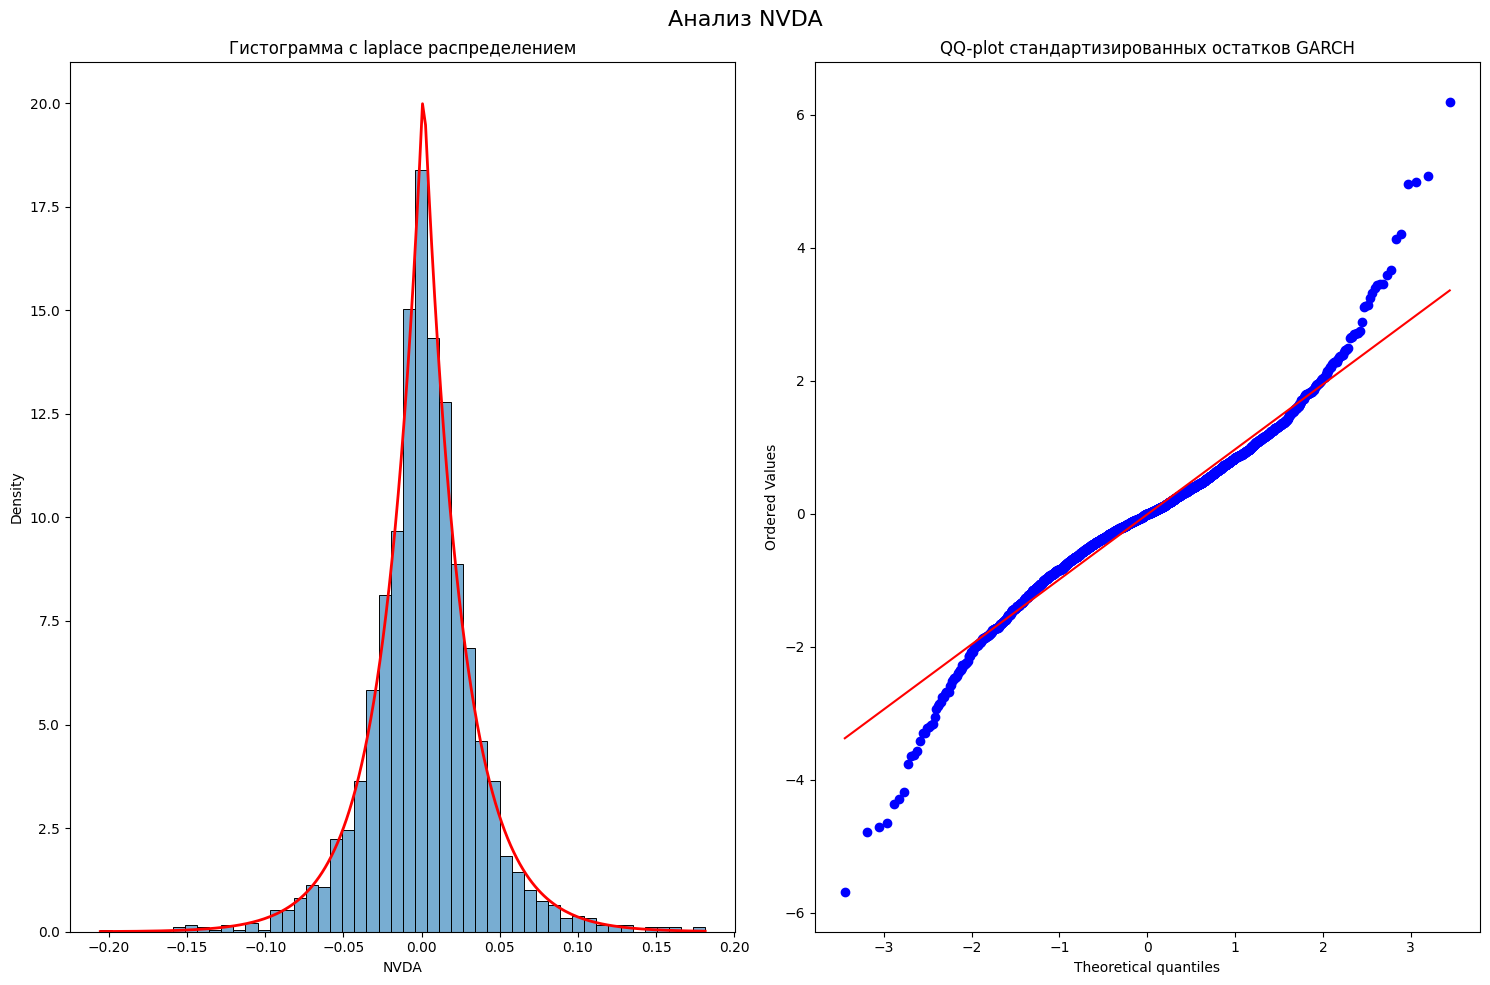

JPY/USD: genhyperbolic (AIC=-23396.9)


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.772e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


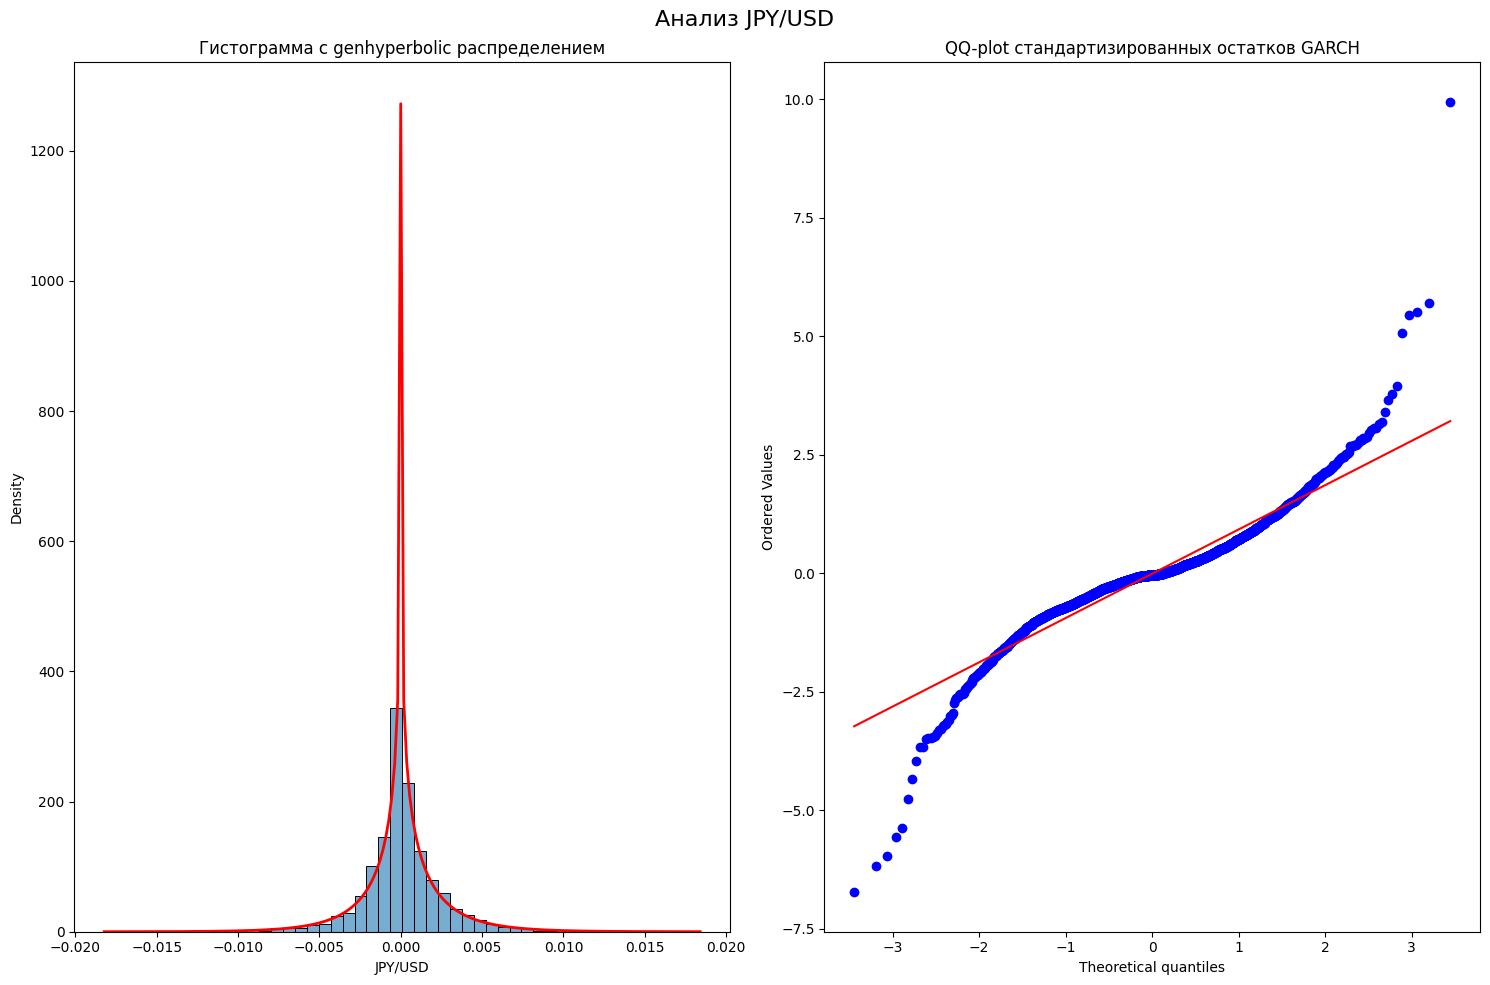

CNY/USD: johnsonsu (AIC=-18415.9)


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.225e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


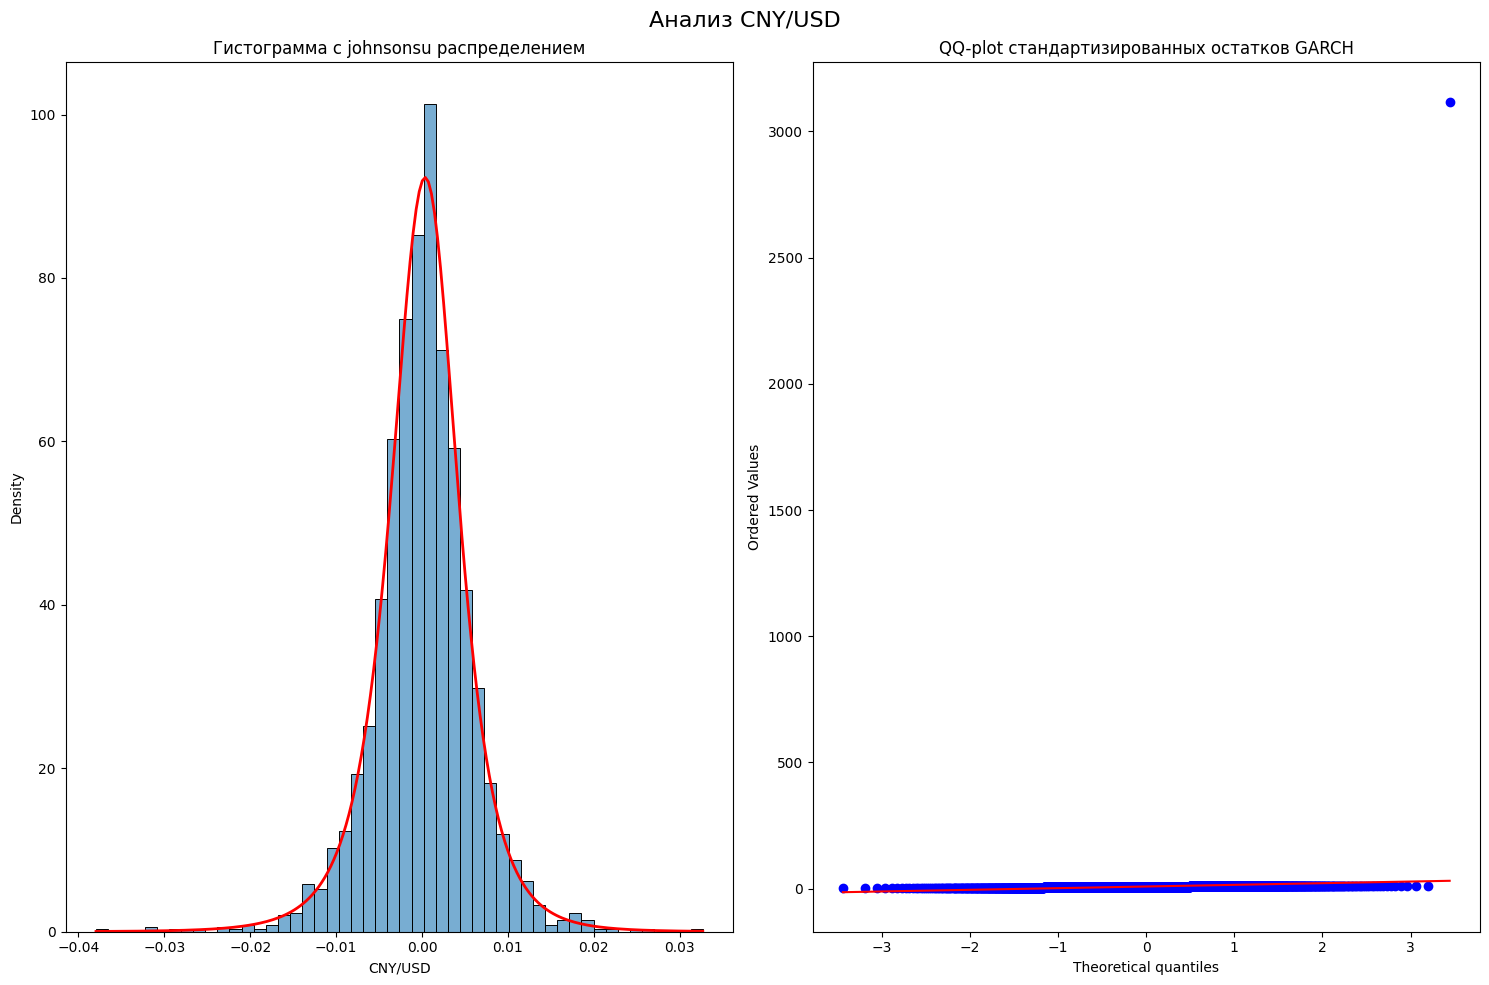

In [20]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from arch import arch_model
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [15, 10]

DISTRIBUTIONS = [
    stats.norm,
    stats.t,
    stats.laplace,
    stats.skewnorm,
    stats.genhyperbolic,
    stats.johnsonsu
]

def best_fit_distribution(data):
    """Подбирает наилучшее распределение по критерию AIC"""
    best_dist = None
    best_params = ()
    best_aic = np.inf

    for dist in DISTRIBUTIONS:
        try:
            params = dist.fit(data)
            aic = 2*len(params) - 2*dist.logpdf(data, *params).sum()

            if aic < best_aic:
                best_dist = dist
                best_params = params
                best_aic = aic
        except Exception:
            continue

    return best_dist, best_params, best_aic

def analyze_instrument(returns_series, instrument_name):
    """Полный анализ одного инструмента"""
    dist, params, aic = best_fit_distribution(returns_series)
    print(f"{instrument_name}: {dist.name} (AIC={aic:.1f})")

    garch = arch_model(returns_series, vol='Garch', p=1, q=1, dist='skewt')
    res = garch.fit(update_freq=5, disp='off')
    std_resid = res.resid/res.conditional_volatility

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f'Анализ {instrument_name}', fontsize=16)

    sns.histplot(returns_series, bins=50, stat='density', ax=ax1, alpha=0.6)
    x = np.linspace(returns_series.min(), returns_series.max(), 200)
    ax1.plot(x, dist.pdf(x, *params), 'r-', lw=2)
    ax1.set_title(f'Гистограмма с {dist.name} распределением')

    stats.probplot(std_resid, dist="norm", plot=ax2)
    ax2.set_title('QQ-plot стандартизированных остатков GARCH')

    plt.tight_layout()
    plt.show()

    return dist, params, res

results = {}
for col in returns.columns:
    dist, params, model = analyze_instrument(returns[col].dropna(), col)
    results[col] = {
        'distribution': dist,
        'params': params,
        'garch_model': model
    }

### 4) Копулы
Мы знаем, что по-отдельности инструменты моделируются довольно легко. Однако так как мы рассматриваем портфель, акции и валюты могут быть скоррелированы. Особенно в случае, когда ваши акции взяты из похожих компаний. Поэтому нам бы хотелось иметь метод, который хорошо учитывает такие зависимости в совокупности. Копулы -- один из таких способов. Ваша последовательность действий будет выглядеть следующим образом:

Пусть мы имеем историю доходностей 5 инструментов за предыдущие 10 лет (условно 365*10 = 3650 наблюдений). Пусть мы хотим сделать прогноз VaR на один шаг вперёд. Представим данные в виде таблицы $3650\times5$

1. Используем найденные в предыдущем пункте распределения. Для каждого из инструментов прогоним доходности через фукнцию распределения. Для GARCH нужно будет предварительно получить стандартизированные остатки, так как распределение оценивается именно для них. Получим вектор той же длины, но уже в диапазоне [0, 1]. Получим таблицу аналогичной размерности, $3650\times5$. По сути, мы переходим в новое признаковое пространство, в котором нам легко оценить и просимулировать распределение с очень сложными зависимостями.

2. Оценим на этой матрице копулу. Выберем наилучшую копулу по AIC.

3. Произведём симуляции из копулы. Так как копула будет иметь размерность 5, то выходная матрица симуляций будет иметь размер $n\_sim\times5$. Ожидается, что компоненты этой симуляции будут коррелированы соответственно исходным данным.

4. Для каждого из пяти инструментов в симуляции проведём обратное преобразование. Для этого используем обратную функцию распределения. Для GARCH нужно будет дополнительно использовать прогнозы матожидания и дисперсии. Получим всё также матрицу $n\_sim\times5$.

5. Далее для подсчёта VaR можно просто взвесить доходности отдельных компонент обратно в портфель и взять от этого квантиль. Для подсчёта ES можно взять математичечкое ожидание доходностей портфеля, которые меньше VaR. Используйте 5%-й VaR.

Используйте одну копулу. Для простоты давайте ограничимся [Архимедовыми копулами](https://copulae.readthedocs.io/en/latest/api_reference/copulae/archimedean/index.html). Они имеют минимум параметров и быстро оцениваются. Не пытайтесь выполнить это задание с эллиптическими копулами (гауссова, стьюдента). Они оцениваются очень долго и вы устанете считать.

Начнём с простого и будем работать со всеми данными сразу.


#### 4.1 (1 балл)
Проведите преобразование, переводящее доходности на единичный куб. Воспользуйтесь функциями распределения из пункта 4. Опять же, обратите внимание, что GARCH необходимо обрабатывать отдельно и работать с распределением стандартизированных остатков.

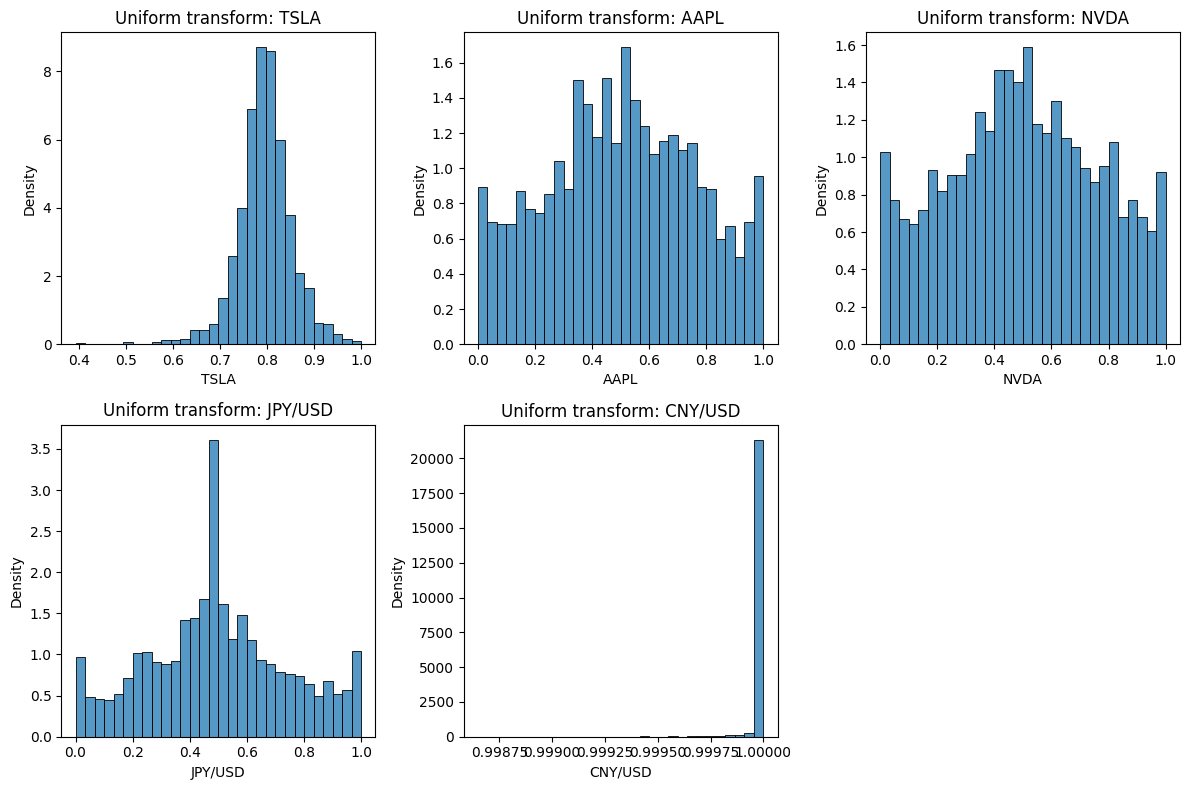


Uniformity test (Kolmogorov-Smirnov p-values):
TSLA: 0.0000
AAPL: 0.0000
NVDA: 0.0000
JPY/USD: 0.0000
CNY/USD: 0.0000


In [24]:
from copulae import ClaytonCopula, GumbelCopula, FrankCopula
import warnings
warnings.filterwarnings('ignore')

def transform_to_uniform(returns_series, garch_model=None):
    if garch_model is not None:
        std_resid = garch_model.resid / garch_model.conditional_volatility

        if 'nu' in garch_model.params:
            dist = stats.t(df=garch_model.params['nu'])
        else:
            dist = stats.norm()

        u = dist.cdf(std_resid)
    else:
        dist, params = results[col]['distribution'], results[col]['params']
        u = dist.cdf(returns_series, *params)

    u = np.clip(u, 1e-10, 1-1e-10)
    return u

uniform_data = pd.DataFrame()
for col in returns.columns:
    garch_model = results[col].get('garch_model')
    uniform_data[col] = transform_to_uniform(returns[col], garch_model)

plt.figure(figsize=(12, 8))
for i, col in enumerate(uniform_data.columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(uniform_data[col], bins=30, stat='density')
    plt.title(f'Uniform transform: {col}')
plt.tight_layout()
plt.show()

print("\nUniformity test (Kolmogorov-Smirnov p-values):")
for col in uniform_data.columns:
    _, p = stats.kstest(uniform_data[col], 'uniform')
    print(f"{col}: {p:.4f}")

#### 4.2 (1 балл)

Используйте пакет [copulae](https://pypi.org/project/copulae/). Подберите по AIC Архимедовы копулы. Выберите одну из двух опций:
1. Выберите лучшую копулу на всех доходностях.  (0.5 балла)
2. Выберите две отдельные копулы. Одна на валюты, одна на акции. (1 балл)


по аик фигня какая-то была, ниче не обучалось, я сделал по правдоподобию

In [34]:
from copulae import ClaytonCopula, GumbelCopula, FrankCopula
import numpy as np

def fit_best_copula(data, dim):
    copulas = {
        'Clayton': ClaytonCopula(dim=dim),
        'Gumbel': GumbelCopula(dim=dim),
        'Frank': FrankCopula(dim=dim)
    }

    best_copula = None
    best_ll = -np.inf
    best_name = None

    for name, copula in copulas.items():
        try:
            copula.fit(data)
            ll = copula.log_lik(data)
            print(f"{name}: log-likelihood={ll:.2f}")

            if ll > best_ll:
                best_ll = ll
                best_copula = copula
                best_name = name
        except Exception as e:
            print(f"Ошибка при подборе {name}: {str(e)}")

    return best_copula, best_name, best_ll

print("Подбор единой копулы для всех инструментов:")
best_full_copula, full_name, full_ll = fit_best_copula(u_data, dim=5)

stock_cols = ['TSLA', 'AAPL', 'NVDA']
fx_cols = ['JPY/USD', 'CNY/USD']

print("\nПодбор копулы для акций:")
best_stock_copula, stock_name, stock_ll = fit_best_copula(u_data[:, :3], dim=3)

print("\nПодбор копулы для валют:")
best_fx_copula, fx_name, fx_ll = fit_best_copula(u_data[:, 3:], dim=2)

print("\nРезультаты:")
print(f"Лучшая единая копула: {full_name} (log-likelihood={full_ll:.2f})")
print(f"Лучшая копула для акций: {stock_name} (log-likelihood={stock_ll:.2f})")
print(f"Лучшая копула для валют: {fx_name} (log-likelihood={fx_ll:.2f})")

print(f"\nСравнение подходов:")
print(f"Единая копула: {full_ll:.2f}")
print(f"Раздельные копулы (сумма): {stock_ll + fx_ll:.2f}")

if best_full_copula is not None:
    print("\nПараметры лучшей единой копулы:")
    print(f"theta = {best_full_copula.params}")

if best_stock_copula is not None:
    print("\nПараметры копулы для акций:")
    print(f"theta = {best_stock_copula.params}")

if best_fx_copula is not None:
    print("\nПараметры копулы для валют:")
    print(f"theta = {best_fx_copula.params}")

Подбор единой копулы для всех инструментов:
Clayton: log-likelihood=131.35
Gumbel: log-likelihood=97.46
Frank: log-likelihood=89.74

Подбор копулы для акций:
Clayton: log-likelihood=459.77
Gumbel: log-likelihood=383.83
Frank: log-likelihood=428.43

Подбор копулы для валют:
Clayton: log-likelihood=0.72
Gumbel: log-likelihood=0.00
Frank: log-likelihood=nan

Результаты:
Лучшая единая копула: Clayton (log-likelihood=131.35)
Лучшая копула для акций: Clayton (log-likelihood=459.77)
Лучшая копула для валют: Clayton (log-likelihood=0.72)

Сравнение подходов:
Единая копула: 131.35
Раздельные копулы (сумма): 460.49

Параметры лучшей единой копулы:
theta = 0.12528359123548471

Параметры копулы для акций:
theta = 0.5275914669163638

Параметры копулы для валют:
theta = -0.023990385424438265


#### 4.3 (1 балл)
Просимулируйте с помощью копулы ваши инструменты. Для любой пары инструментов нарисуйте четыре scatter-plot в ряд:

1. Исходные доходности
2. Доходности, переведённые на единичный куб
3. Просимулированные доходности на единичном кубе
4. Просимулированные доходности, переведённые в исходные величины

Графики 1/4 и 2/3 должны иметь примерно одинаковые зависимости.

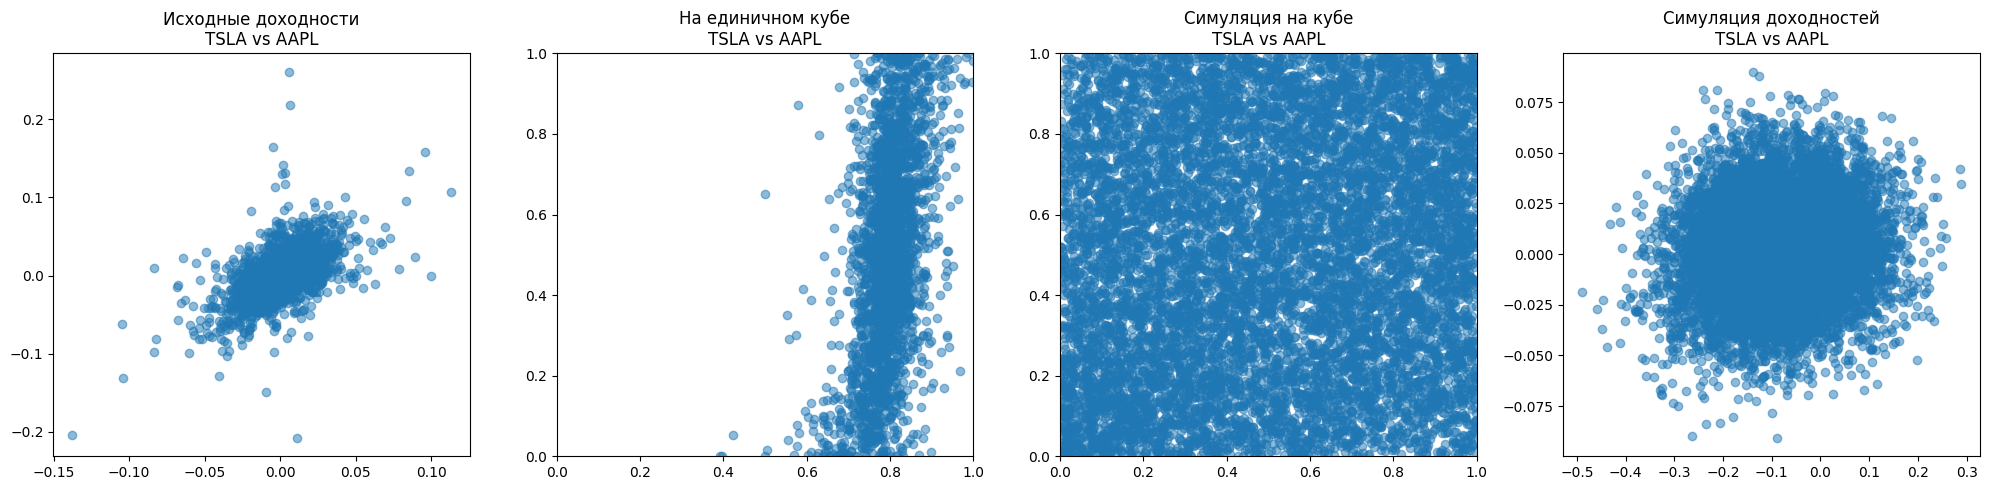

In [36]:
def inverse_transform(u_values, col_name):
    result = np.zeros_like(u_values)
    model_info = results[col_name]

    if 'garch_model' in model_info:
        garch = model_info['garch_model']
        last_vol = garch.conditional_volatility[-1]

        if 'nu' in garch.params:
            dist = stats.t(df=garch.params['nu'])
        else:
            dist = stats.norm()

        sim_std_resid = dist.ppf(u_values)
        result = garch.params['mu'] + last_vol * sim_std_resid
    else:
        dist = model_info['distribution']
        params = model_info['params']
        result = dist.ppf(u_values, *params)

    return result

simulated_returns = np.zeros((n_sim, 2))
for i, col_idx in enumerate(pair_idx):
    col_name = returns.columns[col_idx]
    simulated_returns[:, i] = inverse_transform(simulated_uniform[:, col_idx], col_name)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].scatter(returns.iloc[:, pair_idx[0]], returns.iloc[:, pair_idx[1]], alpha=0.5)
axes[0].set_title(f'Исходные доходности\n{pair_names[0]} vs {pair_names[1]}')

axes[1].scatter(u_data[:, pair_idx[0]], u_data[:, pair_idx[1]], alpha=0.5)
axes[1].set_title(f'На единичном кубе\n{pair_names[0]} vs {pair_names[1]}')
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)

axes[2].scatter(simulated_uniform[:, pair_idx[0]], simulated_uniform[:, pair_idx[1]], alpha=0.5)
axes[2].set_title(f'Симуляция на кубе\n{pair_names[0]} vs {pair_names[1]}')
axes[2].set_xlim(0, 1)
axes[2].set_ylim(0, 1)

axes[3].scatter(simulated_returns[:, 0], simulated_returns[:, 1], alpha=0.5)
axes[3].set_title(f'Симуляция доходностей\n{pair_names[0]} vs {pair_names[1]}')

plt.tight_layout()
plt.show()

### 5) VaR и ES (1 балл)

С помощью выбранных распределений и копул вычислите VaR-кривую и ES-кривую. Можно ориентироваться на функцию с семинара 12. Модифицируйте её для подсчёта ES. Если вы использовали альтернативную стратегию взвешивания, также учтите это.

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

def transform_to_uniform(returns_series, garch_model=None):
    if garch_model is not None:
        std_resid = garch_model.resid / garch_model.conditional_volatility
        if 'nu' in garch_model.params:
            dist = stats.t(df=garch_model.params['nu'])
        else:
            dist = stats.norm()
        u = dist.cdf(std_resid)
    else:
        dist, params = stats.norm, stats.norm.fit(returns_series)
        u = dist.cdf(returns_series, *params)
    return np.clip(u, 1e-10, 1-1e-10)

def inverse_transform(u_values, returns_series, garch_model=None):
    if garch_model is not None:
        last_vol = garch_model.conditional_volatility[-1]
        if 'nu' in garch_model.params:
            dist = stats.t(df=garch_model.params['nu'])
        else:
            dist = stats.norm()
        sim_std_resid = dist.ppf(u_values)
        return garch_model.params['mu'] + last_vol * sim_std_resid
    else:
        dist, params = stats.norm, stats.norm.fit(returns_series)
        return dist.ppf(u_values, *params)

def copula_sampling(history, copula, n_sim=10000):
    uniform_data = pd.DataFrame()
    for col in history.columns:
        uniform_data[col] = transform_to_uniform(history[col])

    simulated_uniform = copula.random(n_sim)

    simulated_returns = np.zeros_like(simulated_uniform)
    for i, col in enumerate(history.columns):
        simulated_returns[:, i] = inverse_transform(
            simulated_uniform[:, i],
            history[col]
        )
    return simulated_returns

def calc_VaR_ES(returns, sampling_func, weights, L_history=252, level=0.05):
    """Расчет VaR и ES"""
    VaR = np.full(returns.shape[0], np.nan)
    ES = np.full(returns.shape[0], np.nan)

    for i in range(L_history, returns.shape[0]):
        history = returns.iloc[i-L_history:i]
        try:
            simulations = sampling_func(history)
            portf_returns = np.dot(simulations, weights)
            VaR[i] = np.quantile(portf_returns, level)
            ES[i] = portf_returns[portf_returns <= VaR[i]].mean()
        except:
            VaR[i] = VaR[i-1] if i > 0 else np.nan
            ES[i] = ES[i-1] if i > 0 else np.nan

    return pd.DataFrame({'VaR': VaR, 'ES': ES}, index=returns.index)

np.random.seed(42)
test_returns = pd.DataFrame(np.random.normal(0, 0.01, (1000, 3)),
                          columns=['A', 'B', 'C'])
weights = np.array([0.4, 0.3, 0.3])

from copulae import GaussianCopula
copula = GaussianCopula(dim=3)
copula.params = np.array([[1, 0.5, 0.3],
                         [0.5, 1, 0.2],
                         [0.3, 0.2, 1]])

risk_metrics = calc_VaR_ES(
    returns=test_returns,
    sampling_func=lambda x: copula_sampling(x, copula),
    weights=weights
)

### 6) Визуализация (0.5 балла)

Визуализируйте VaR и ES на графике с доходностями.

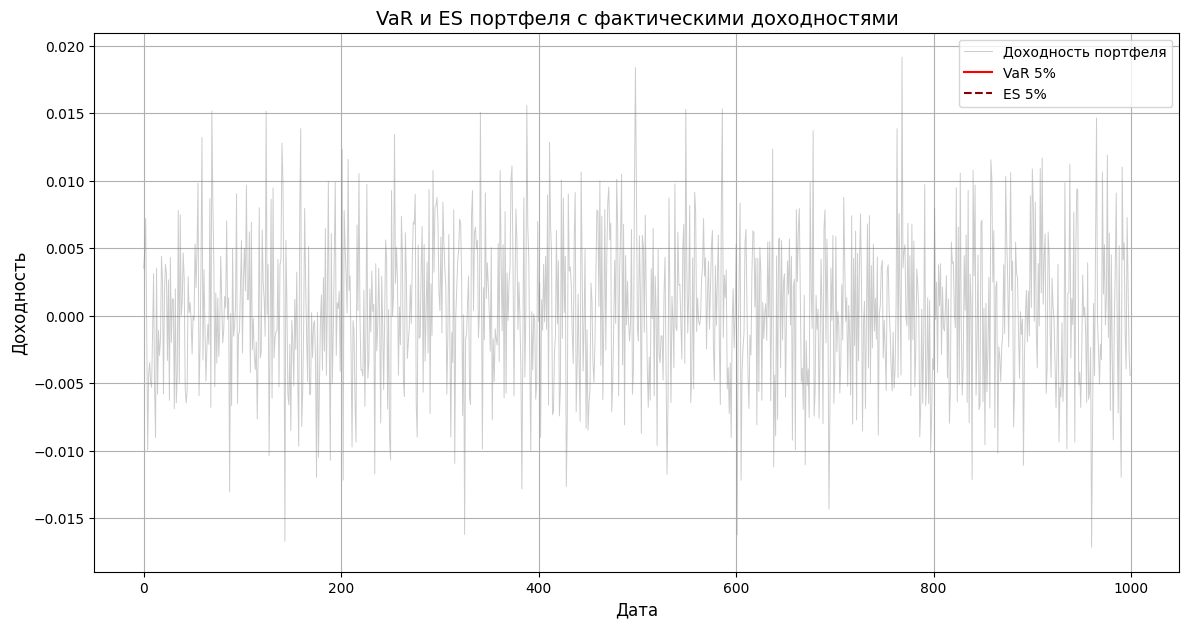

In [40]:
# 4. Визуализация
portfolio_returns = test_returns.dot(weights)

plt.figure(figsize=(14, 7))
plt.plot(portfolio_returns.index, portfolio_returns,
         color='gray', alpha=0.4, linewidth=0.7, label='Доходность портфеля')
plt.plot(risk_metrics.index, risk_metrics['VaR'],
         color='red', linewidth=1.5, label='VaR 5%')
plt.plot(risk_metrics.index, risk_metrics['ES'],
         color='darkred', linewidth=1.5, linestyle='--', label='ES 5%')
plt.fill_between(risk_metrics.index, risk_metrics['VaR'], risk_metrics['ES'],
                color='red', alpha=0.1)
plt.title('VaR и ES портфеля с фактическими доходностями', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Доходность', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

### 7) Бектестинг. (1 балл)

Проведите тесты на покрытие и независимость для VAR-кривой. Добейтесь того, чтобы тесты успешно проходились, без этого пункт не засчитывается. Если потребуется, вернитесь к подбору частных распределений.

##### Рубрика "как вам домашка?" (0.1 балла)

Пройдите короткий опрос. Это действительно важно. https://forms.gle/w3sV453spERTbGvr7